In [223]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx as nx
import time
import matplotlib.pyplot as plt
import pickle
import numpy as np
from seirsplus.utilities import load_model, save_model, convert_percentage_to_scale
# from seirsplus.networks import prune_graph_per_age
plt.rcParams["figure.figsize"] = (12, 6)
import pandas as pd
import os
from scipy.interpolate import interp1d


In [224]:
acc_data = pd.read_csv("../accumulated_data_for_sim.csv")

In [225]:
def get_percentage_people_per_age_group(people_per_age, ages):
    n_total = people_per_age.num_people.sum()
    percentage_per_age = {}
    for a in ages:
        n_people = people_per_age[(people_per_age.age>=a[0]) & (people_per_age.age<=a[1])].num_people.sum()
        percentage = 100 * n_people/n_total
        percentage_per_age[a] = percentage
    return percentage_per_age

In [4]:
vacc_data = pd.read_csv("../../israel_data/vaccination_data_for_simulation.csv")


In [5]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
folder = 'third_wave_simulation/'

In [166]:
ages_str = ['0-9',  '10-19','20-29','30-39','40-49','50-59','60-69','70-79', '80-100']
ages_per = [(int(a.split('-')[0]), int(a.split('-')[1])) for a in ages_str]
ages_dist_dict = get_percentage_people_per_age_group(people_per_age, ages_per)
age_dist = np.array(list(ages_dist_dict.values()))/100

[1.6, 0, [0, 0], 0.9, 1, 1688.944622615185, 0]
[1.6, 0, [0, 0], 0.9, 1, 2614.948125032481, 1]
[1.6, 0, [0, 0], 0.9, 1, 2453.115728320499, 2]
[1.6, 0, [0, 0], 0.9, 1, 1464.6709724631212, 3]
[1.6, 0, [0, 0], 0.9, 1, 1464.6709724631212, 4]
[1.6, 0, [0, 0], 0.9, 1, 1497.0664346287617, 5]
[1.6, 0, [0, 0], 0.9, 1, 1497.0664346287617, 6]
[1.6, 0, [0, 0], 0.9, 1, 1573.1282109984295, 7]
[1.6, 0, [0, 0], 0.9, 1, 1573.1282109984295, 8]
[1.6, 0, [0, 0], 0.9, 1, 1466.777684550967, 9]
[1.6, 0, [0, 0], 0.9, 1, 2137.3855516899457, 10]
[1.6, 0, [0, 0], 0.9, 1, 1470.0621614835802, 11]
[1.6, 0, [0, 0], 0.9, 1, 1453.1439780575083, 12]
[1.6, 0, [0, 0], 0.9, 1, 1458.823184276659, 13]
[1.6, 0, [0, 0], 0.9, 1, 1966.1326472408798, 14]
[1.6, 0, [0, 0], 0.9, 1, 1610.483210979202, 15]
[1.6, 0, [0, 0], 0.9, 1, 1966.1326472408798, 16]
[1.6, 0, [0, 0], 0.9, 1, 1539.8137428055722, 17]
[1.6, 0, [0, 0], 0.9, 1, 1542.3887248334245, 18]
[1.6, 0, [0, 0], 0.9, 1, 1637.1108578971312, 19]
[1.6, 0, [0, 0], 0.9, 1, 1454.979212

<ipython-input-226-130b0ae37452>:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)


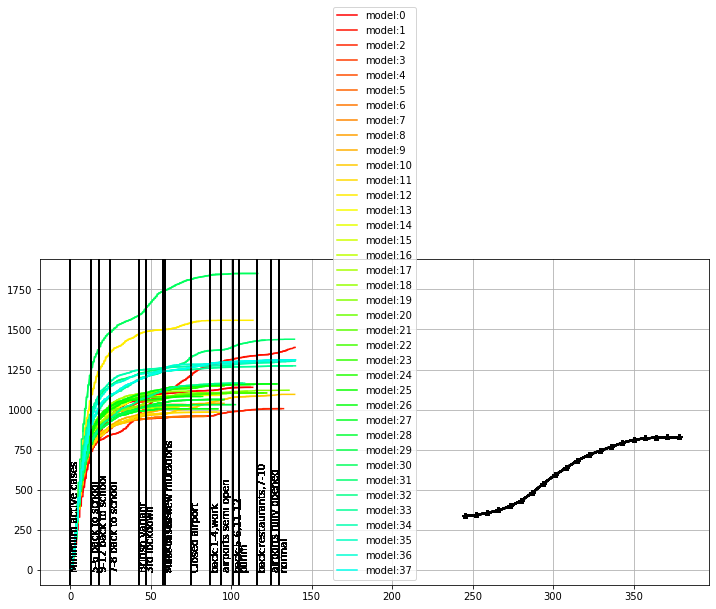

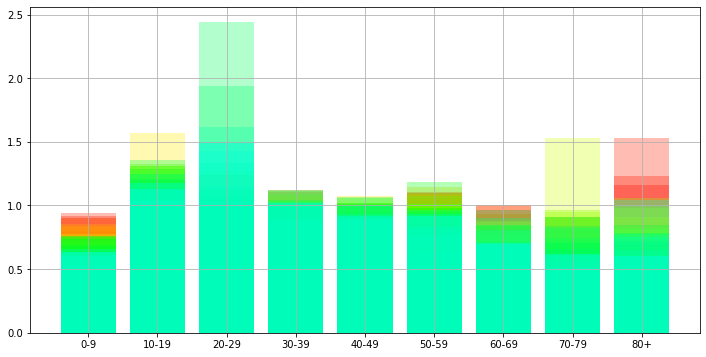

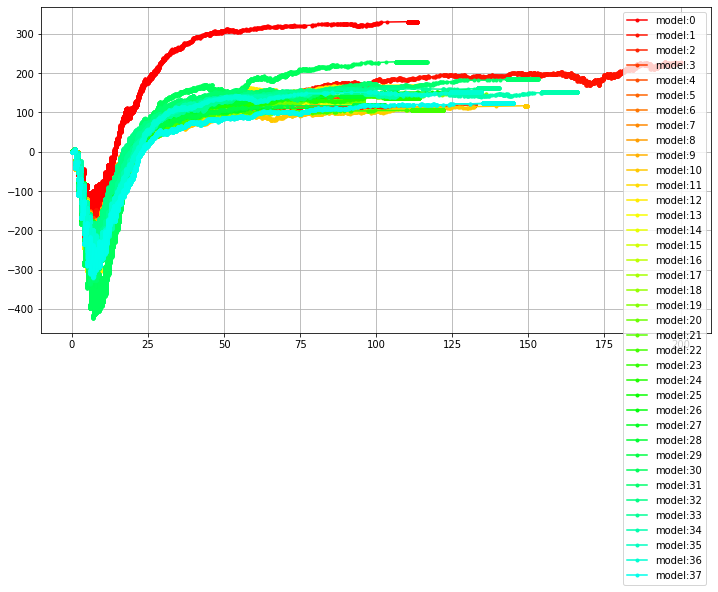

<Figure size 864x432 with 0 Axes>

In [226]:
# N = 10000
i_color = 0
directory ='test_simulation' +("/")+'2021_04_21'
files_name = os.listdir(directory)
colors = get_cmap(len(files_name))
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = acc_data.weeks_from * 7
acc_cases = acc_data.accumulated_cases_country



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['R0_factor',
                'q_global_adults', 'q_global_kids', 'percentage_edges_removed_vacc', 'seed']
plt.figure()

models_to_plot = range(int(len(files_name)/2))

for i in models_to_plot:
    max_time = 140
    min_time = 8
    
    config_name = "input_config"+str(models_to_plot[i])
    path_name_config = f"{directory}/{config_name}"
    
    model_name = "model"+str(i)
    path_name_model = f"{directory}/{model_name}"
    
    with open(f"{path_name_config}.pickle", 'rb') as handle:
        config_load=  pickle.load(handle)
        
    
    with open(f"{path_name_model}.pickle", 'rb') as handle:
        model_load=  pickle.load(handle)
    
    
    relevant_input = [config_load[k] for k in relevant_keys]
    N = config_load['N']
    
    data['model'].append(model_load)
    data['input_config'].append(config_load)
    
    time_ind = np.where(data['model'][i].tseries<=max_time)[0]
    
     
    model_data = data['model'][i].numPositive[time_ind]
    time_to_plot = data['model'][i].tseries[time_ind]
    smooth_model = moving_average(model_data, np.ceil(data['model'][i].numPositive.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numPositive.shape[0] / 100).astype(int))

    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = np.max([min_time, smooth_time.min()+1])
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time, acc_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_to_plot, model_data, color=colors[i_color], label=f'model:{i}')
    ax.plot(time_scale, model_out, color=colors[i_color])
    ax.plot(time[35:], acc_cases[35:] * N / 9200000, marker='*', color='k', linewidth=2)
    for t, e in zip(times_for_sim, event):
        ax.axvline(int(t), 0, 1, c='k')
        ax.text(int(t)+0.1, 0, str(e), rotation=90)
#     ax.plot(time_scale, real_data, '-k', marker='.')
#     ax.plot(data['model'][i].tseries, (data['model'][i].numR + data['model'][i].numQ_R), label="num recovered", marker='*', color='r')
#     ax.plot(data['model'][i].tseries, (data['model'][i].numPositive), label="num positive", marker='.', color='g')
    
    ax2.plot(data['model'][i].tseries, (data['model'][i].numR + data['model'][i].numQ_R) - (data['model'][i].numPositive), label=f'model:{i}', marker='.', color=colors[i_color])
    model_diff = np.linalg.norm((model_out - real_data)/time_scale.size)
    relevant_input.append(model_diff)
    relevant_input.append(i)
    print(relevant_input)

    
#     age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    x_k = []
    y_m = []
    for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
        num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
#         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
#         y_m.append((mean_age/age_dist[num]).astype(float))
#     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
    ax1.bar(x_k,y_m, color=colors[i_color], alpha=0.3)
#     relevant_input.append(np.array(y_m))
    data['relevant_data'].append(relevant_input)
    i_color += 1
ax.legend()
ax2.legend()
ax2.grid()

relevant_keys.append('model_diff')
relevant_keys.append('folder_num')
ax1.grid()
ax.grid()

input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)

alpha:[0.3 0.6 0.8 1.  1.4 1.5 1.7 2.9]
alpha:[0.3 0.6 0.8 1.  1.4 1.5 1.7 2.9]
alpha:[0.5 0.8 1.  1.2 1.5]
alpha:[0.5 0.8 1.  1.2]
alpha:[0.5 0.8 1.  1.2 1.5]


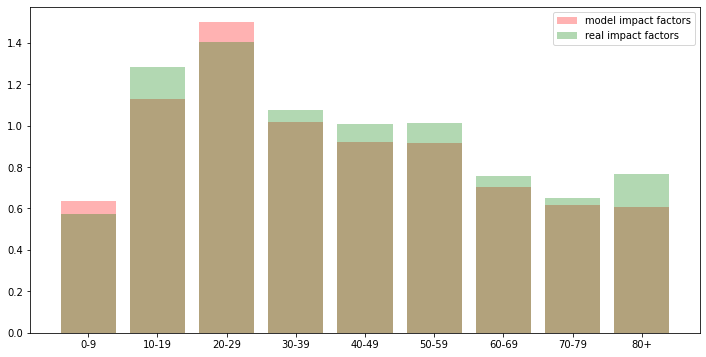

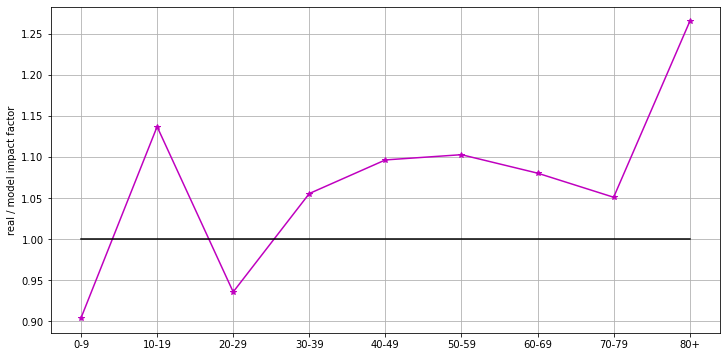

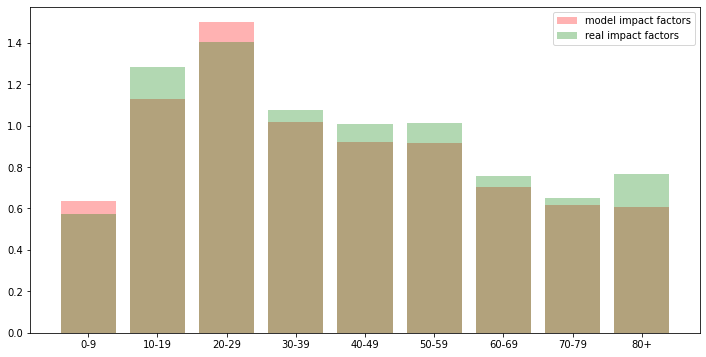

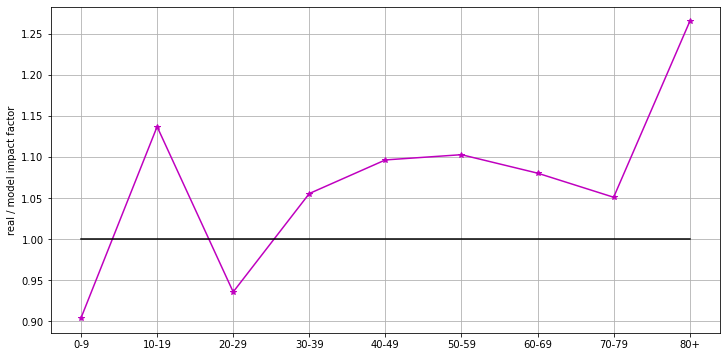

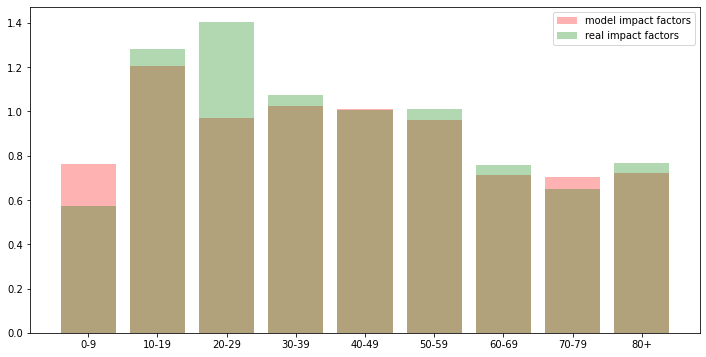

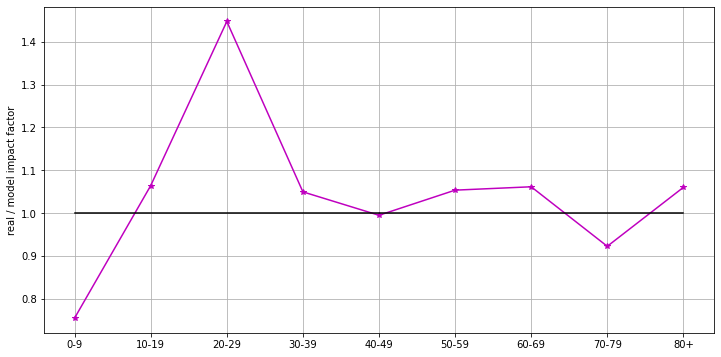

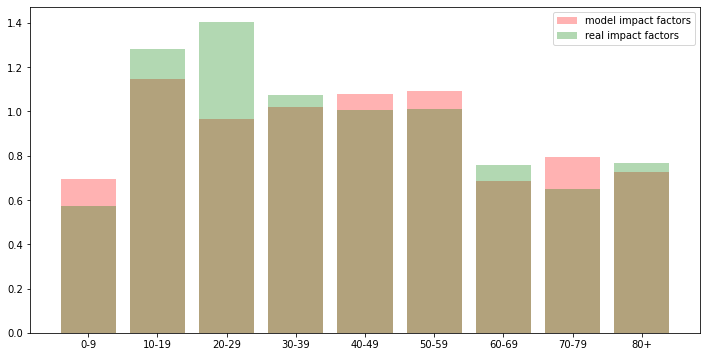

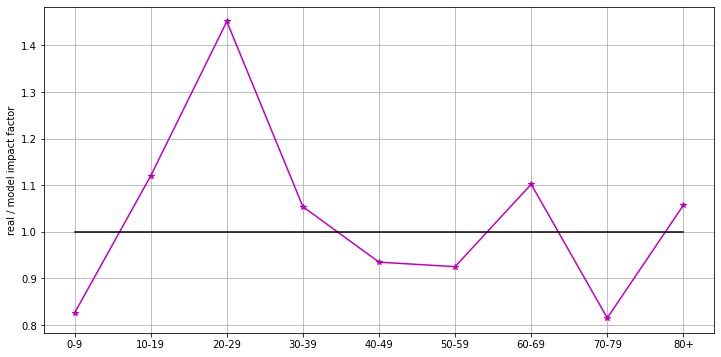

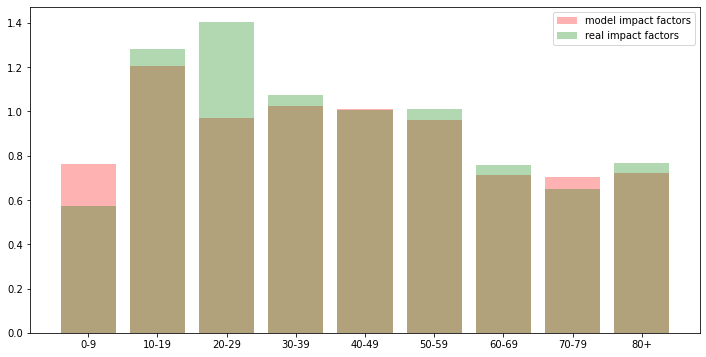

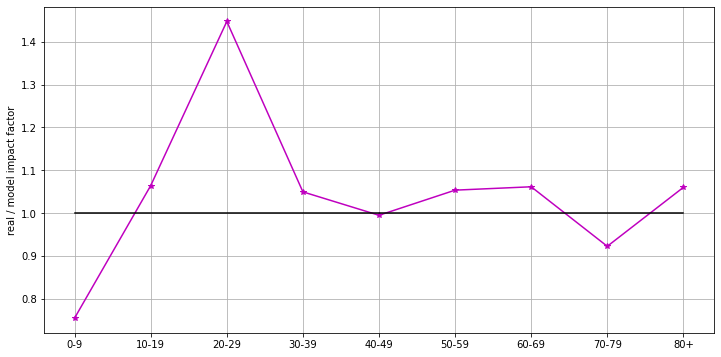

In [220]:
models = [-1,-3, 28, 11, 23]
for m in models:
    model_temp = data['model'][m]
    print(f"alpha:{np.unique(model_temp.alpha)}")
    model_temp.numPositive[-1] /model_temp.numR[-1]
    x_k = []
    y_m = []
    N = model_temp.X.size
    for num, key in enumerate(model_temp.nodeGroupData.keys()):
        num_nodes = model_temp.nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(model_temp.nodeGroupData[key]['numPositive']/(model_temp.numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
    model_impact_factors_dict = {x: y for x,y in zip(x_k, y_m)}
    plt.figure()
    plt.bar(x_k,y_m, color='r', alpha=0.3, label="model impact factors")

    with open(f"../../israel_data/impact_factor_dict.pickle", 'rb') as handle:
            real_factor_dict_input =  pickle.load(handle)
    people_per_age = pd.read_csv("../../israel_data/num_people_per_age.csv")
    ages_impact_factor = [(int(a.split('-')[0]), int(a.split('-')[1])) for a in list(import_factor_dict.keys())]
    ages_impact_factor.append((0, 8))
    ages_impact_factor.append((9, 19))
    ages_impact_factor.append((20, 29))
    ages_impact_factor.append((30, 39))
    ages_impact_factor.append((40, 49))
    ages_impact_factor.append((50, 59))
    ages_impact_factor.append((60, 69))
    ages_impact_factor.append((70, 79))
    ages_impact_factor.append((80, 100))
    percentages_each_age = get_percentage_people_per_age_group(people_per_age, ages_impact_factor)
    real_factor_dict = {'0-9': (real_factor_dict_input['0-2'] * percentages_each_age[(0, 2)] + 
                                        real_factor_dict_input['3-5'] * percentages_each_age[(3, 5)] + 
                                        real_factor_dict_input['6-8'] * percentages_each_age[(6, 8)])/ percentages_each_age[(0, 8)],  
     '10-19': (real_factor_dict_input['9-11'] * percentages_each_age[(9, 11)] + 
                                        real_factor_dict_input['12-14'] * percentages_each_age[(12, 14)] + 
                                        real_factor_dict_input['15-17'] * percentages_each_age[(15, 17)] + 
                                        real_factor_dict_input['18-20'] * percentages_each_age[(18, 20)])/ percentages_each_age[(9, 19)],  
     '20-29': (real_factor_dict_input['20-24'] * percentages_each_age[(20, 24)] +  
               real_factor_dict_input['25-29'] * percentages_each_age[(25, 29)])/ percentages_each_age[(20, 29)],  
     '30-39': (real_factor_dict_input['30-34'] * percentages_each_age[(30, 34)] +  
               real_factor_dict_input['35-39'] * percentages_each_age[(35, 39)])/ percentages_each_age[(30, 39)], 
     '40-49': (real_factor_dict_input['40-44'] * percentages_each_age[(40, 44)] +  
               real_factor_dict_input['45-49'] * percentages_each_age[(45, 49)])/ percentages_each_age[(40, 49)],  
     '50-59': (real_factor_dict_input['50-54'] * percentages_each_age[(50, 54)] +  
               real_factor_dict_input['55-59'] * percentages_each_age[(55, 59)])/ percentages_each_age[(50, 59)], 
     '60-69': (real_factor_dict_input['60-64'] * percentages_each_age[(60, 64)] +  
               real_factor_dict_input['65-69'] * percentages_each_age[(65, 69)])/ percentages_each_age[(60, 69)],
     '70-79': (real_factor_dict_input['70-74'] * percentages_each_age[(70, 74)] +  
               real_factor_dict_input['75-79'] * percentages_each_age[(75, 79)])/ percentages_each_age[(70, 79)], 
     '80+': real_factor_dict_input['80-100']}
    x_k = []
    y_m = []
    for key, value in real_factor_dict.items():
        x_k.append(key)
        y_m.append(value)
    plt.bar(x_k, y_m, color='g', alpha=0.3, label="real impact factors")
    plt.legend()
    diff_impact_factors = np.array(list(real_factor_dict.values())) / np.array(list(model_impact_factors_dict.values()))
    plt.figure()
    plt.plot(real_factor_dict.keys(), diff_impact_factors, marker='*', color='m')
    plt.plot([0, 8], [1, 1], color='k')
    plt.ylabel("real / model impact factor")
    plt.grid()

In [190]:
data['model'][11].G, data['model'][11].G_Q, data['model'][11].nodeGroupData

(<networkx.classes.graph.Graph at 0x7f5fd222c400>,
 {'0-9': {'nodes': array([   0,    1,    2, ..., 1866, 1867, 1868]),
   'mask': array([[ True],
          [ True],
          [ True],
          ...,
          [False],
          [False],
          [False]]),
   'numS': array([1778., 1778., 1778., ..., 1703., 1717., 1717.]),
   'numE': array([74., 74., 74., ...,  0.,  0.,  0.]),
   'numI_pre': array([0., 0., 0., ..., 0., 0., 0.]),
   'numI_sym': array([0., 0., 0., ..., 0., 0., 0.]),
   'numI_asym': array([0., 0., 0., ..., 0., 0., 0.]),
   'numH': array([0., 0., 0., ..., 0., 0., 0.]),
   'numR': array([  0.,   0.,   0., ..., 151., 152., 152.]),
   'numF': array([0., 0., 0., ..., 0., 0., 0.]),
   'numQ_S': array([17.,  0.,  0., ..., 14.,  0.,  0.]),
   'numQ_E': array([17., 17., 17., ...,  0.,  0.,  0.]),
   'numQ_pre': array([0., 0., 0., ..., 0., 0., 0.]),
   'numQ_sym': array([0., 0., 0., ..., 0., 0., 0.]),
   'numQ_asym': array([0., 0., 0., ..., 0., 0., 0.]),
   'numQ_R': array([17.,  

In [ ]:
# self.S = 1
# self.E = 2
# self.I_pre = 3
# self.I_sym = 4
# self.I_asym = 5
# self.H = 6
# self.R = 7
# self.F = 8
# self.Q_S = 11
# self.Q_E = 12
# self.Q_pre = 13
# self.Q_sym = 14
# self.Q_asym = 15
# self.Q_R = 17

In [66]:
# # time_line = [5, 30, 60, 90, 115, 120, 137, 150, 160]
# # events = ['hofesh gadol', 'close <50,20', 'close work', 'schools back', 'full seger', 'maximum-72k',
# #          'kindergarden back', 'grades 1-4 back', 'minimum-8000']
# m_to_plot = [8, 3, 19, 6]
# real_factors = []
# fig, ax = plt.subplots(1, 1)
# fig1, ax1 = plt.subplots(1, 1)

# for m in m_to_plot: 
#     max_time = 130
#     min_time = 7
#     model_2 = data["model"][m]
# #     print(input_df.iloc()[13, :])
#     N = 10000
#     times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
#     event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
#              '7-8 back to school', 'British variant', '3rd lockdown',
#              'schools close', 'Most cases new mutations', 'Closed airport',
#              'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
#              'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']
#     time_ind = np.where(model_2.tseries<=max_time)[0]
    
    
#     model_data = (((model_2.numI_sym+model_2.numH)*9e6)/N)[time_ind]
#     time_to_plot = model_2.tseries[time_ind]
    
#     smooth_model = moving_average(model_data, np.ceil(model_2.numI_sym.shape[0] / 100).astype(int))
#     smooth_time = moving_average(time_to_plot, np.ceil(model_2.numI_sym.shape[0] / 100).astype(int))
    
#     max_time = np.min([max_time, smooth_time.max()-1])
#     min_time = np.max([min_time, smooth_time.min()+1])
#     time_scale = np.arange(min_time, max_time, 1)
#     f_real_data = interp1d(time+7, active_cases)
#     real_data = f_real_data(time_scale)
#     f_model = interp1d(smooth_time, smooth_model)
#     model_out = f_model(time_scale)
#     ax.plot(time_scale, model_out, color=colors[m], label=f'model:{m}', marker='*')
    
# #     plt.plot(model_2.tseries, ((model_2.numI_sym+model_2.numH)*9e6)/N)
#     for time, event in zip(times_for_sim, event):
#         ax.axvline(int(time) + 7, 0, 1, c='k')
#         ax.text(int(time)+0.1 + 7, 0, str(event), rotation=90)

#     time = numpy.load('third_wave_simulation/time_3rd_wave.npy')
#     active_casese = numpy.load('third_wave_simulation/active_cases_3rd_wave.npy')
#     ax.plot(time + 7, active_casese, '-r')

#     age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
#     for num, key in enumerate(model_2.nodeGroupData.keys()):
#         mean_age = np.mean(model_2.nodeGroupData[key]['numPositive']/(model_2.numPositive+1e-5))
#         ax1.bar(key,(mean_age/age_dist[num]).astype(float))

# #     fig, ax = model_2.figure_infections(combine_Q_infected=False)
# #     plt.show()
# #     model_2.numE /model_2.numI_sym
# ax.legend()